# Try false NN methods
## Try with more variables / higher dimension observations

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import chirp
from functools import partial # Import this due to weird lambda behavior
import system_dynamics
import networks
import embed_dynamics
from importlib import reload
%load_ext tensorboard
from sklearn.feature_selection import mutual_info_regression
from scipy.stats import gaussian_kde
from sklearn.neighbors import KernelDensity
from sklearn.metrics import mutual_info_score
import sys, importlib
from dynamics_methods import *
from embedding_methods import *
from scipy.stats import entropy
from scipy.signal import argrelextrema
from scipy.signal import find_peaks

In [17]:
importlib.reload(sys.modules["embedding_methods"])
# importlib.reload(sys.modules["system_dynamics"])
from embedding_methods import *
reload(embed_dynamics)

<module 'embed_dynamics' from '/Users/zz/Documents/GT 20X/phml/NN_toy_examples/embed_dynamics.py'>

In [248]:
# find_delay_by_FNN(X, ratio=10, pred=1, stop_threshold=0, max_tau=100, max_dim=10, uniform_delay=True, 
#                      init_i=0, try_all_i=False, end_early=True, verbose=False)
find_delay_by_FNN_Garcia(X[[1]], ratio=10, pred=1, stop_threshold=0, max_tau=30, max_dim=10, uniform_delay=True,
                         init_i=0, end_early=True, verbose=True)

Starting the 1-th embedding cycle
At delay=1 using j=0 for de=0: average d1 = 0.06968420856195355; average d2 = 0.11774608829289585
49 out of 9968 samples counted as false neighbors
At delay=2 using j=0 for de=0: average d1 = 0.09896129490169821; average d2 = 0.13158791177978088
26 out of 9968 samples counted as false neighbors
At delay=3 using j=0 for de=0: average d1 = 0.12035402798290967; average d2 = 0.146706023639754
42 out of 9968 samples counted as false neighbors
Found first local min at j=0, tau=2 as the 1-th delay
Updated F value from the 1-th embedding cycle is 0


([2], [0])

In [3]:
# Test out the chosen delay value. Set up nets.
tf.keras.backend.clear_session()
seed = 2020
opt_alg = 'adam'
activation = 'tanh' # 'relu' # 'tanh'
output_activation = 'none'
log_root_dir = 'Fma_logs/'
input_mask = [1] # Allows x(1); doesn't allow t(0), y(2), z(3), u(4).
Nlayer = 2
Nneuron = 5
# The delay and dimension come from the original paper.
de = 3
dint = [2, 2]

net_listD = []
# Add two more models that don't use symmetry
for i in range(len(sys_list)):
    net_listD.append(
        embed_dynamics.NN_Delay(
            sys_list[i], input_mask, seed=seed, log_dir=log_root_dir+sys_names[i], tensorboard=False,
            Nlayer=Nlayer, Nneuron=Nneuron, activation=activation, output_activation=output_activation, optimizer=opt_alg, 
            de=de, delay_int=dint[i], sym=False
        )
    )
net_names = [ sys_names[i]+'-{0}DE-{1}*{2}, forward'.format(de, dint[i], dt) for i in range(len(sys_names))]

# Construct models
for nn in net_listD:
    nn.construct()


NameError: name 'sys_list' is not defined

In [ ]:
# Train models. 
Epoch = 200
for nn in net_listD:
    nn.train(epoch=Epoch, inds=[0]) # inds is the dataset selected for training
    nn.summary()

In [ ]:
# # Plot systems that try to learn the full state - error plot
# fig, axs = plot_tests( test_inds=[0,1], net_list=net_listD, net_inds=[1], out_list=[0,1,2], 
#                        net_names=net_names, u_names=['train0','test1'], out_names=['x','y','z'],
#                        datatype='l2', log_mode=True, plot_skip_rate=100, 
#                        title='Prediction of full state when given x as training input\n' )
# Plot systems that try to learn the full state - trajectory plot
fig, axs = plot_tests( test_inds=[0,1], net_list=net_listD, net_inds=[1], out_list=[0,1,2], 
                       net_names=net_names, u_names=['train0','test1'], out_names=['x','y','z'],
                       datatype='traj', log_mode=False, plot_skip_rate=100, 
                       title='Prediction of full state when given x as training input\n' )
# # Plot systems that try to learn z from x - error plot
# fig, axs = plot_tests( test_inds=[0,1], net_list=net_listD, net_inds=[0], out_list=[0], 
#                        net_names=net_names, u_names=['train0','test1'], out_names=['z'],
#                        datatype='l2', log_mode=True, plot_skip_rate=100, 
#                        title='Prediction of z when given x as training input\n' )
# # Plot systems that try to learn z from x - trajectory plot
# fig, axs = plot_tests( test_inds=[0,1], net_list=net_listD, net_inds=[0], out_list=[0], 
#                        net_names=net_names, u_names=['train0','test1'], out_names=['z'],
#                        datatype='traj', log_mode=False, plot_skip_rate=100, 
#                        title='Prediction of z when given x as training input\n' )

In [473]:
importlib.reload(sys.modules["embedding_methods"])
from embedding_methods import *
reload(embed_dynamics)
reload(system_dynamics)

<module 'system_dynamics' from '/Users/zz/Documents/GT 20X/phml/NN_toy_examples/system_dynamics.py'>

In [3]:
t0 = 0
t1 = 100 
dt = 0.01 
ts_steps = np.arange(t0, t1, dt)
u_func_list = [
    # We don't need input here. Just place a placeholder.
    lambda t : 0*t, 
    lambda t : 0*t
]
# init_list = [ np.random.randn(7)*4, np.random.randn(7)*5 ]
init_list = [ np.ones(7), np.ones(7)+np.random.randn(7)*0.2 ]
u_names = ['.']
pred=1

gly_sys = embed_dynamics.GlycolyticFullState(t0=t0, tf=t1, dt=dt, pred=pred)#, output_inds=[0,1,2,3,4,5,6])
gly012_sys = embed_dynamics.GlycolyticFullState(t0=t0, tf=t1, dt=dt, pred=pred)#output_inds=[0,1,2,3,4,5,6], )
sys_list = [gly_sys, gly012_sys]
sys_names = ['Gly full state','Gly 012 state']

# Make some data generation input functions
for syst in sys_list:
    syst.add_u_func( u_func_list, init_list )
#     syst.data_generator()
# A quick and dirty way to add another "test set" that uses longer time
for syst in sys_list:
    syst.add_u_func( u_func_list[0], init_list[0], (t0, t1*10, dt) )
for syst in sys_list:
    syst.data_generator()

u_names=['train0','test1','train_long']
out_names=['S1','S2','S3','S4','S5','S6','S7']

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


(<Figure size 864x216 with 2 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x145733a20>,
       dtype=object))

<Figure size 432x288 with 0 Axes>

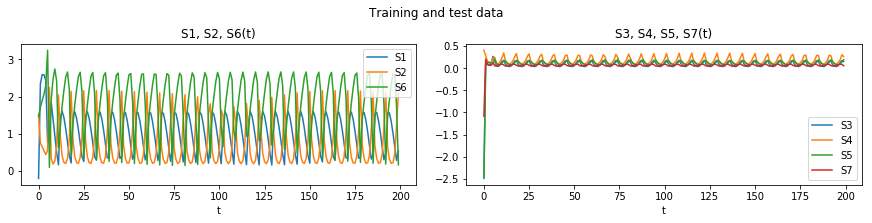

In [5]:
glyyyy_sys = embed_dynamics.GlycolyticFullState(t0=t0, tf=t1, dt=dt, pred=pred)
# glyyyy_sys.add_u_func( [u_func_list[0]], np.ones(7)*0.5+np.random.randn(7)*1.5 )
glyyyy_sys.add_u_func( [u_func_list[0]], np.array([
    -0.20380494, 1.50691938, -2.49574082, 0.41356985, -2.47331202, 1.47229205, -1.08367559]), (t0, t1*2, dt) )
glyyyy_sys.data_generator()
glyyyy_sys.plot_dataset(title='Training and test data', plot_skip_rate=100)

In [483]:
glyyyy_sys.init

[array([-0.20380494,  1.50691938, -2.49574082,  0.41356985, -2.47331202,
         1.47229205, -1.08367559])]

<Figure size 432x288 with 0 Axes>

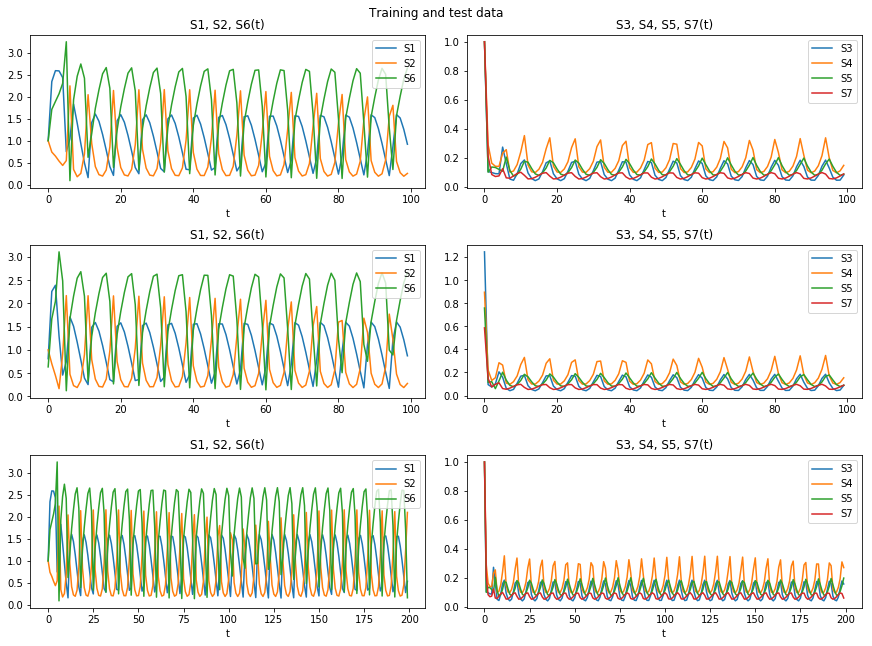

In [6]:
fig,axs = gly_sys.plot_dataset(title='Training and test data', plot_skip_rate=100)

In [30]:
# find_delay_by_FNN(X, ratio=10, pred=1, stop_threshold=0, max_tau=100, max_dim=10, uniform_delay=True, 
#                      init_i=0, try_all_i=False, end_early=True, verbose=False)
# Briefly test out the FNN method. Notice that the first row of Inputset[i] is time, and should be excluded.
# Used ratio=1.75 for S1-S3 here. 
find_delay_by_FNN_Garcia(gly_sys.Inputset[0][4:7,:], ratio=1.05, pred=1, stop_threshold=0, min_tau=1, max_tau=20, max_dim=10,
                         init_i=0, end_early=True, verbose=True)

Starting the 1-th embedding cycle
At delay=1 using j=0 for de=0: average d1 = 0.002058570292932118; average d2 = 0.002053064826081894
53 out of 9978 samples counted as false neighbors
At delay=1 using j=1 for de=0: average d1 = 0.0018629184036009529; average d2 = 0.0018616648770645291
113 out of 9978 samples counted as false neighbors
At delay=1 using j=2 for de=0: average d1 = 0.0023317960892064575; average d2 = 0.0025543172537630544
2983 out of 9978 samples counted as false neighbors
At delay=2 using j=0 for de=0: average d1 = 0.0020524129760296403; average d2 = 0.002049964277571727
97 out of 9978 samples counted as false neighbors
At delay=2 using j=1 for de=0: average d1 = 0.0018614597507200033; average d2 = 0.0018624776984182078
101 out of 9978 samples counted as false neighbors
At delay=2 using j=2 for de=0: average d1 = 0.002463246361565663; average d2 = 0.0026865684420829417
2989 out of 9978 samples counted as false neighbors
[[1.         1.         1.        ]
 [0.00531169 0.0

([0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 7, 3, 3, 1, 1, 1, 1],
 [0.00531168570855883,
  0.014934349002706224,
  0.017141138732959103,
  0.017042606516290727,
  0.016051364365971106,
  0.014049172102358254,
  0.012648062638024492,
  0.012649332396345749,
  0.012751004016064257,
  0.012752284365900191])

In [31]:
# Test out the chosen delay value. Set up nets.
tf.keras.backend.clear_session()
seed = 2020
opt_alg = 'adam'
activation = 'tanh' # 'relu' # 'tanh'
output_activation = 'none'
log_root_dir = 'Fma_logs/'
# input_masks = [ [1,2,3,4,5,6,7], 
#                 [1,2,3] ] # Allows S1-S3
input_masks = [ [4,5,6], 
                [1,2,7] ] 
Nlayer = 2
Nneuron = 5

net_listF = []
# Add two more models that don't use symmetry
for i in range(len(sys_list)):
    net_listF.append(
        embed_dynamics.NN_Garcia(
            sys_list[i], input_masks[i], ratio=1, stop_threshold=0, max_tau=20, max_de=10, verbose=True,
            seed=seed, log_dir=log_root_dir+sys_names[i], tensorboard=False,
            Nlayer=Nlayer, Nneuron=Nneuron, activation=activation, output_activation=output_activation, optimizer=opt_alg
        )
    )
net_names = [ sys_names[i]+'-NN' for i in range(len(sys_list)) ]

# Construct models
for nn in net_listF:
    nn.construct()


Starting the 1-th embedding cycle
At delay=1 using j=0 for de=0: average d1 = 0.002058570292932118; average d2 = 0.002053064826081894
3681 out of 9978 samples counted as false neighbors
At delay=1 using j=1 for de=0: average d1 = 0.0018629184036009529; average d2 = 0.0018616648770645291
4213 out of 9978 samples counted as false neighbors
At delay=1 using j=2 for de=0: average d1 = 0.0023317960892064575; average d2 = 0.0025543172537630544
6963 out of 9978 samples counted as false neighbors
At delay=2 using j=0 for de=0: average d1 = 0.0020524129760296403; average d2 = 0.002049964277571727
3688 out of 9978 samples counted as false neighbors
At delay=2 using j=1 for de=0: average d1 = 0.0018614597507200033; average d2 = 0.0018624776984182078
4230 out of 9978 samples counted as false neighbors
At delay=2 using j=2 for de=0: average d1 = 0.002463246361565663; average d2 = 0.0026865684420829417
7003 out of 9978 samples counted as false neighbors
[[1.         1.         1.        ]
 [0.368911

In [32]:
# Train models. 
Epoch = 200
for nn in net_listF:
    nn.train(epoch=Epoch, inds=[0]) # inds is the dataset selected for training
    nn.summary()

Train on 9989 samples
Epoch 1/200
9989/9989 [==============================] - 1s 142us/sample - loss: 0.4245
Epoch 2/200
9989/9989 [==============================] - 0s 36us/sample - loss: 0.1228
Epoch 3/200
9989/9989 [==============================] - 0s 36us/sample - loss: 0.0987
Epoch 4/200
9989/9989 [==============================] - 0s 35us/sample - loss: 0.0804
Epoch 5/200
9989/9989 [==============================] - 0s 41us/sample - loss: 0.0684
Epoch 6/200
9989/9989 [==============================] - 0s 44us/sample - loss: 0.0598
Epoch 7/200
9989/9989 [==============================] - 0s 42us/sample - loss: 0.0548
Epoch 8/200
9989/9989 [==============================] - 0s 42us/sample - loss: 0.0525
Epoch 9/200
9989/9989 [==============================] - 0s 38us/sample - loss: 0.0511
Epoch 10/200
9989/9989 [==============================] - 0s 39us/sample - loss: 0.0500
Epoch 11/200
9989/9989 [==============================] - 0s 38us/sample - loss: 0.0491
Epoch 12/200
9989/

In [454]:
gly_sys.Inputset[0].shape

(9, 10000)

In [39]:
# Plotting helper function...
# This one is modified to suite FNN. Don't remove it too soon. 
def plot_tests(test_inds, net_list, net_inds, out_list, net_names, u_names, out_names,
               datatype='traj', log_mode=False, plot_skip_rate=1, title=''):
    # Arguments:
    # test_inds: indices of test dataset to be plotted
    # net_list : neural nets (containing their own dynamics). Don't pass one in if its dynamics size is weird.
    # out_list : indices of output values you want to see. This assumes those indices apply to all dynamics.
    # datatype : Type of data that's going to be plotted
    # log_mode : whether the plots are in log scale or not
    plt.clf()
    results_list = [nn.test(inds=test_inds,squeeze=False) for nn in net_list]
    if log_mode:
        logtxt = 'log '
    else:
        logtxt = ''
    
    # datatype decides what appears on the plot
    
    Noutput = len(out_list)
    Nrow = (len(net_inds)) * Noutput # Leave the final 2 rows for aggregated plots
    Ncol = len(test_inds)
    fig,axs = plt.subplots(Nrow, Ncol, constrained_layout=True, figsize = (max(15,Ncol*4),Nrow*3), squeeze=False)
#     figt,axst = plt.subplots(Noutput, Ncol, constrained_layout=True, figsize = (Ncol*4,Noutput*4), squeeze=False)
    
    for j in range(len(test_inds)):
        # For each test dataset (each column), plot all models' reactions
        jj = test_inds[j]
        
        # For each network, find its prediction and plot corresponding outputs
        for n in range(len(net_inds)):
            nn = net_inds[n]
            # Find its time series. 
            time_series = np.squeeze(results_list[nn][3][jj])
#             time_series = results_list[nn][2][jj][:,0,-1]
            # Above: [nn] - Take the nn-th network's result; [2] - The 3rd element in result is Inputset;
            #        [jj] - Take the jj-th test run's result; 
            #        [:,0,-1] means take all frames(:), first row (0, where we stored time), last value (-1),
            #          where we take the last value because that's where the output data matches.
            
            # Find the correct thing that we want to plot.
            if datatype == 'l2':
                result = np.square(results_list[nn][0][jj] - results_list[nn][1][jj])
            elif datatype == 'l1':
                result = np.abs(results_list[nn][0][jj] - results_list[nn][1][jj])
            # Don't need to do anything else when it's 'traj'.
            else:
                result = results_list[nn][0][jj]
            if log_mode:
                result = np.log(result)
            
            # Make individual plots for each output, where the indexing fun begins
            for i in range(Noutput):
                ii = out_list[i]
                # print(results_list[nn][1][jj].shape)
#                 print(time_series)
#                 print(result.shape)
#                 print(n, i, n + len(net_inds)*i, j)
                make_axs_plot(
                    axs = axs[n + len(net_inds)*i][j], time = time_series, data = result[:,ii],
                    title = logtxt+datatype+' of '+out_names[i]+'\n for '+net_names[nn]+'\n on input '+u_names[jj],
                    datatype = datatype, data2 = results_list[nn][1][jj][:,ii], 
                    leglist = [net_names[nn], 'True value'], skip = plot_skip_rate
                )
                #print(n + len(net_inds)*i, j, result[:,ii].shape)
                
                # Also draw this network's plot onto the overlay plots over all networks
#                 axst[i][j].plot(time_series[::plot_skip_rate], result[::plot_skip_rate,ii])
        
#         for i in range(Noutput):
#             axst[i][j].set_title( datatype+' of '+out_names[i]+'\n on input '+u_names[jj] )
#             axst[i][j].legend(net_names)
            
    fig.suptitle(title)
#     figt.suptitle('Overlaying result for '+title)
    return fig, axs

def make_axs_plot(axs, time, data, title, datatype, data2=None, leglist=[], skip=1):
    axs.plot(time[::skip], data[::skip])
#     print(time.shape, data2.shape)
    axs.set_title(title)
    axs.set_xlabel('t')
    if datatype == 'traj':
        axs.plot(time[::skip], data2[::skip])
        axs.legend(leglist)
    return axs

Dimensions: Outputset = (9989, 7, 1), results = (9989, 7, 1)
Dimensions: Outputset = (9983, 7, 1), results = (9983, 7, 1)


<Figure size 432x288 with 0 Axes>

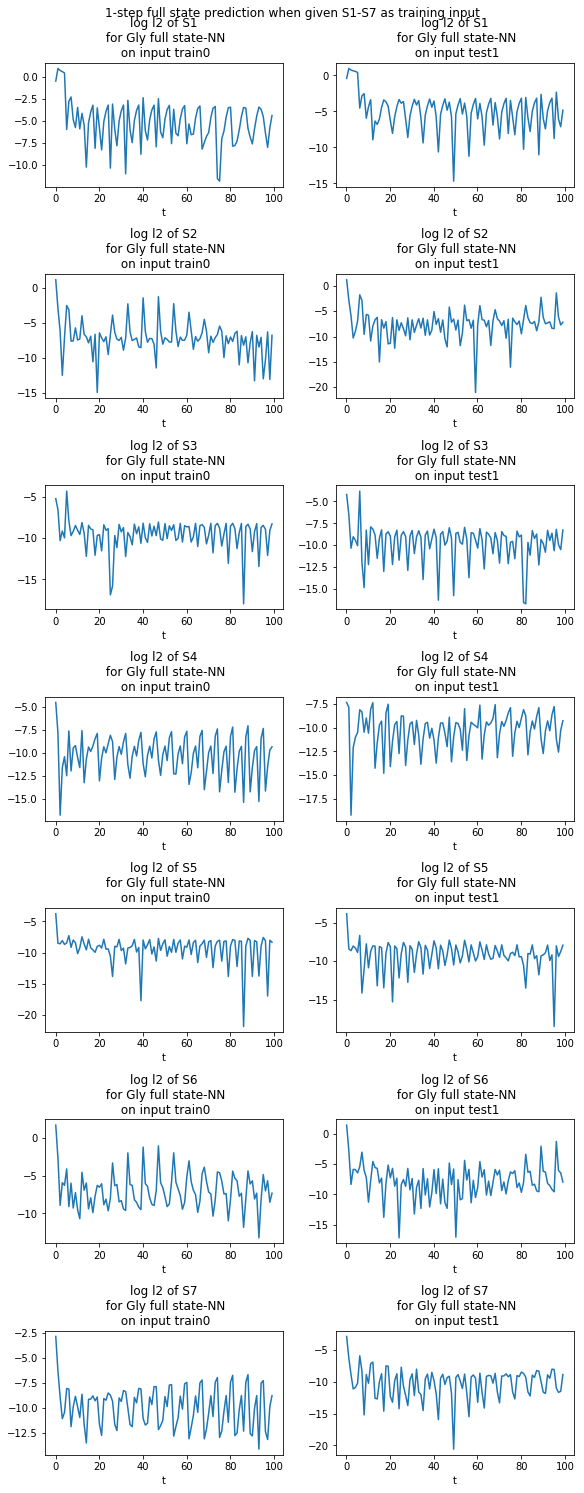

In [37]:
fig, axs = plot_tests( test_inds=[0,1], net_list=net_listF, net_inds=[0], out_list=[0,1,2,3,4,5,6], 
                       net_names=net_names, u_names=u_names, out_names=out_names,
                       datatype='l2', log_mode=True, plot_skip_rate=100, 
                       title='1-step full state prediction when given S1-S7 as training input\n' )

Dimensions: Outputset = (9989, 7, 1), results = (9989, 7, 1)
Dimensions: Outputset = (9983, 7, 1), results = (9983, 7, 1)


<Figure size 432x288 with 0 Axes>

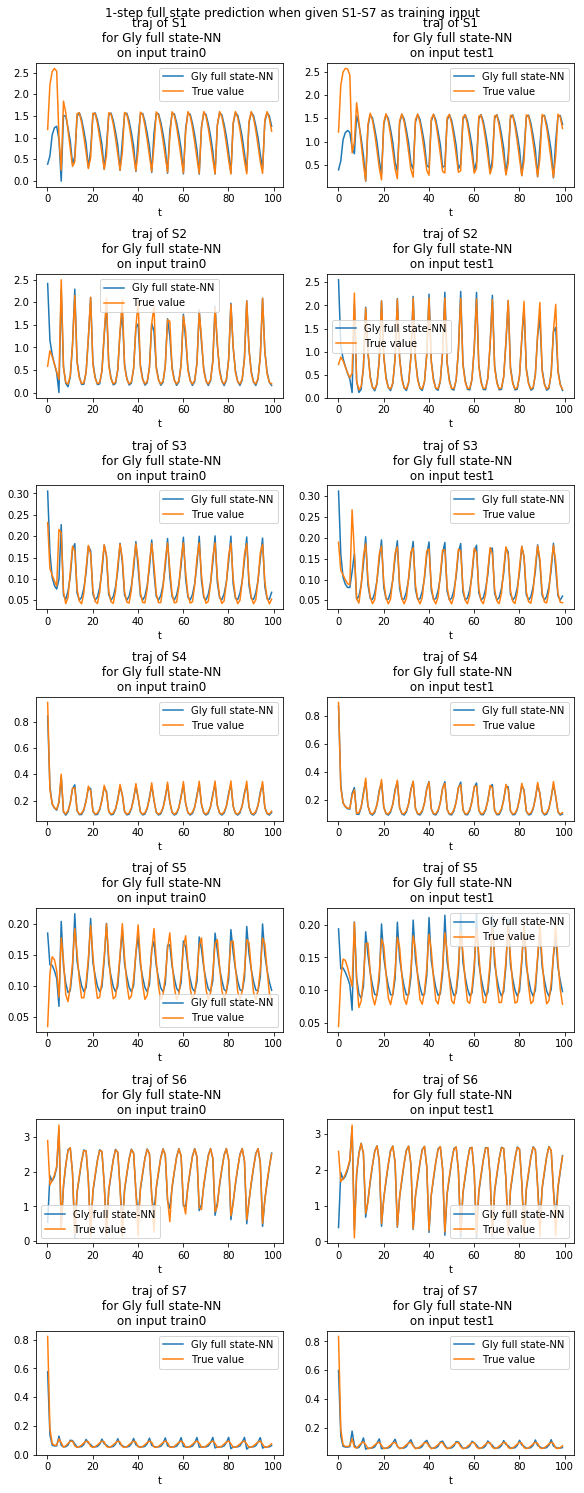

In [36]:
fig, axs = plot_tests( test_inds=[0,1], net_list=net_listF, net_inds=[0], out_list=[0,1,2,3,4,5,6], 
                       net_names=net_names, u_names=u_names, out_names=out_names,
                       datatype='traj', log_mode=False, plot_skip_rate=100, 
                       title='1-step full state prediction when given S1-S7 as training input\n' )

Dimensions: Outputset = (9989, 7, 1), results = (9989, 7, 1)
Dimensions: Outputset = (9983, 7, 1), results = (9983, 7, 1)


<Figure size 432x288 with 0 Axes>

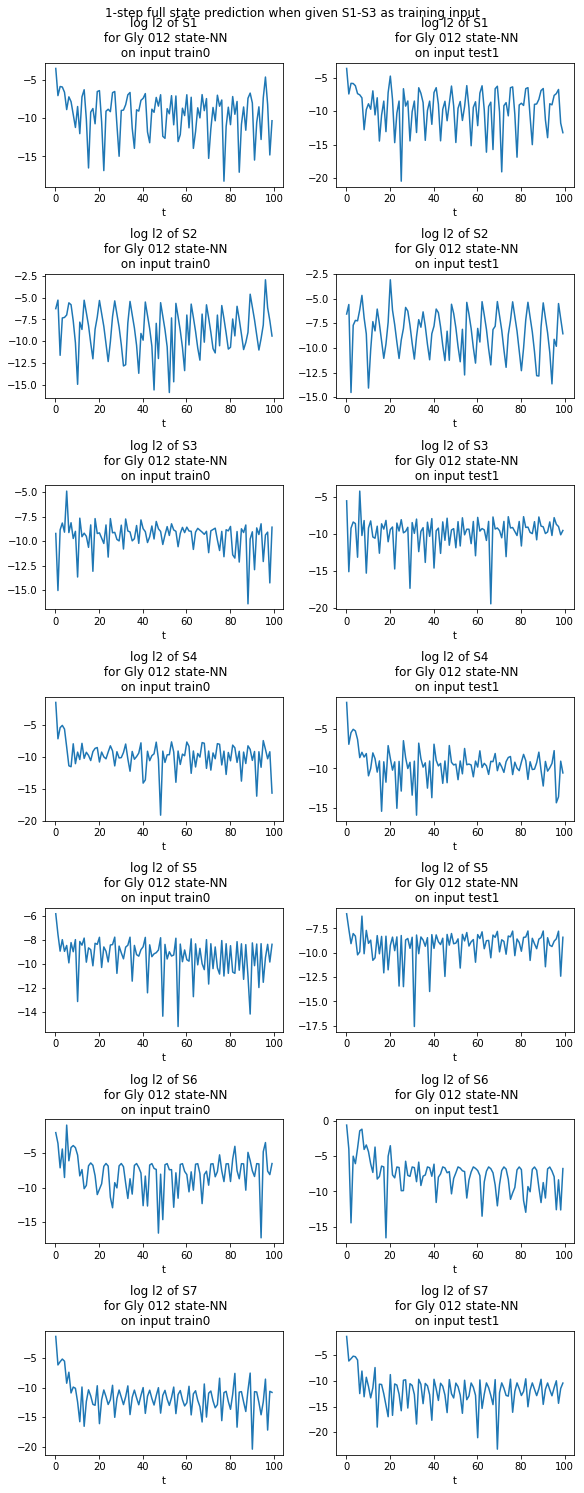

In [34]:
fig, axs = plot_tests( test_inds=[0,1], net_list=net_listF, net_inds=[1], out_list=[0,1,2,3,4,5,6], 
                       net_names=net_names, u_names=u_names, out_names=out_names,
                       datatype='l2', log_mode=True, plot_skip_rate=100, 
                       title='1-step full state prediction when given S1-S3 as training input\n' )

Dimensions: Outputset = (9989, 7, 1), results = (9989, 7, 1)
Dimensions: Outputset = (9983, 7, 1), results = (9983, 7, 1)


<Figure size 432x288 with 0 Axes>

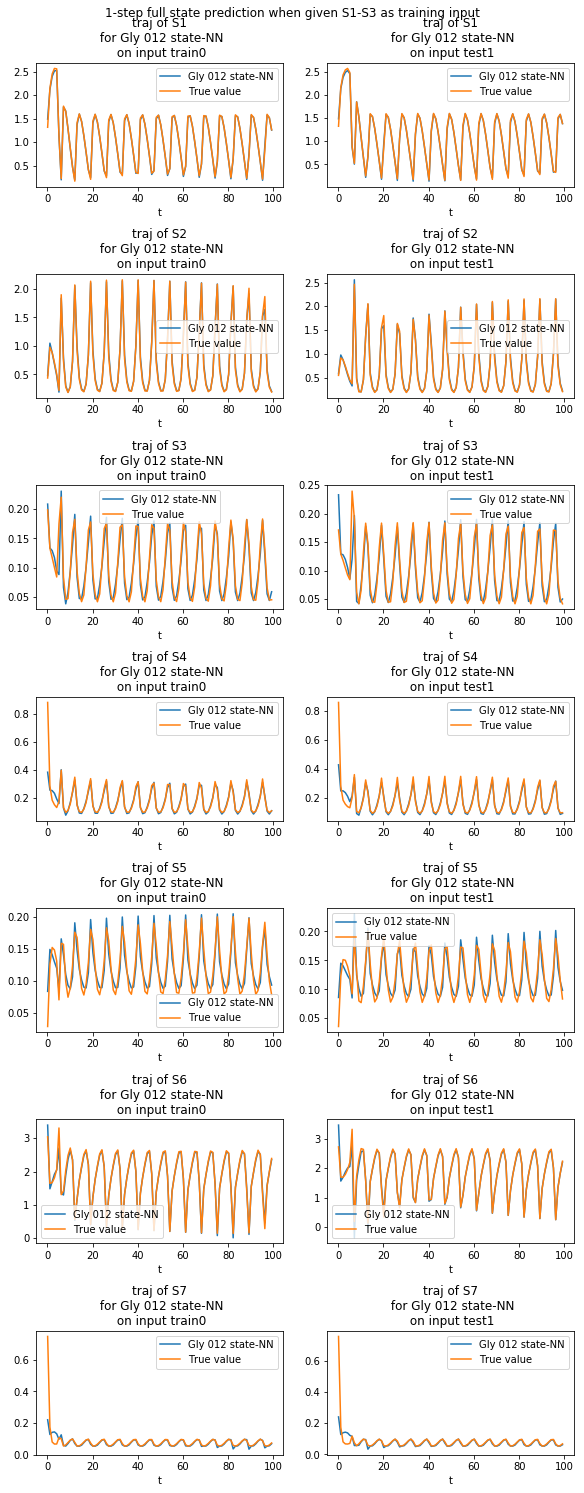

In [35]:
fig, axs = plot_tests( test_inds=[0,1], net_list=net_listF, net_inds=[1], out_list=[0,1,2,3,4,5,6], 
                       net_names=net_names, u_names=u_names, out_names=out_names,
                       datatype='traj', log_mode=False, plot_skip_rate=100, 
                       title='1-step full state prediction when given S1-S3 as training input\n' )

Dimensions: Outputset = (9989, 7, 1), results = (9989, 7, 1)
Dimensions: Outputset = (9983, 7, 1), results = (9983, 7, 1)


<Figure size 432x288 with 0 Axes>

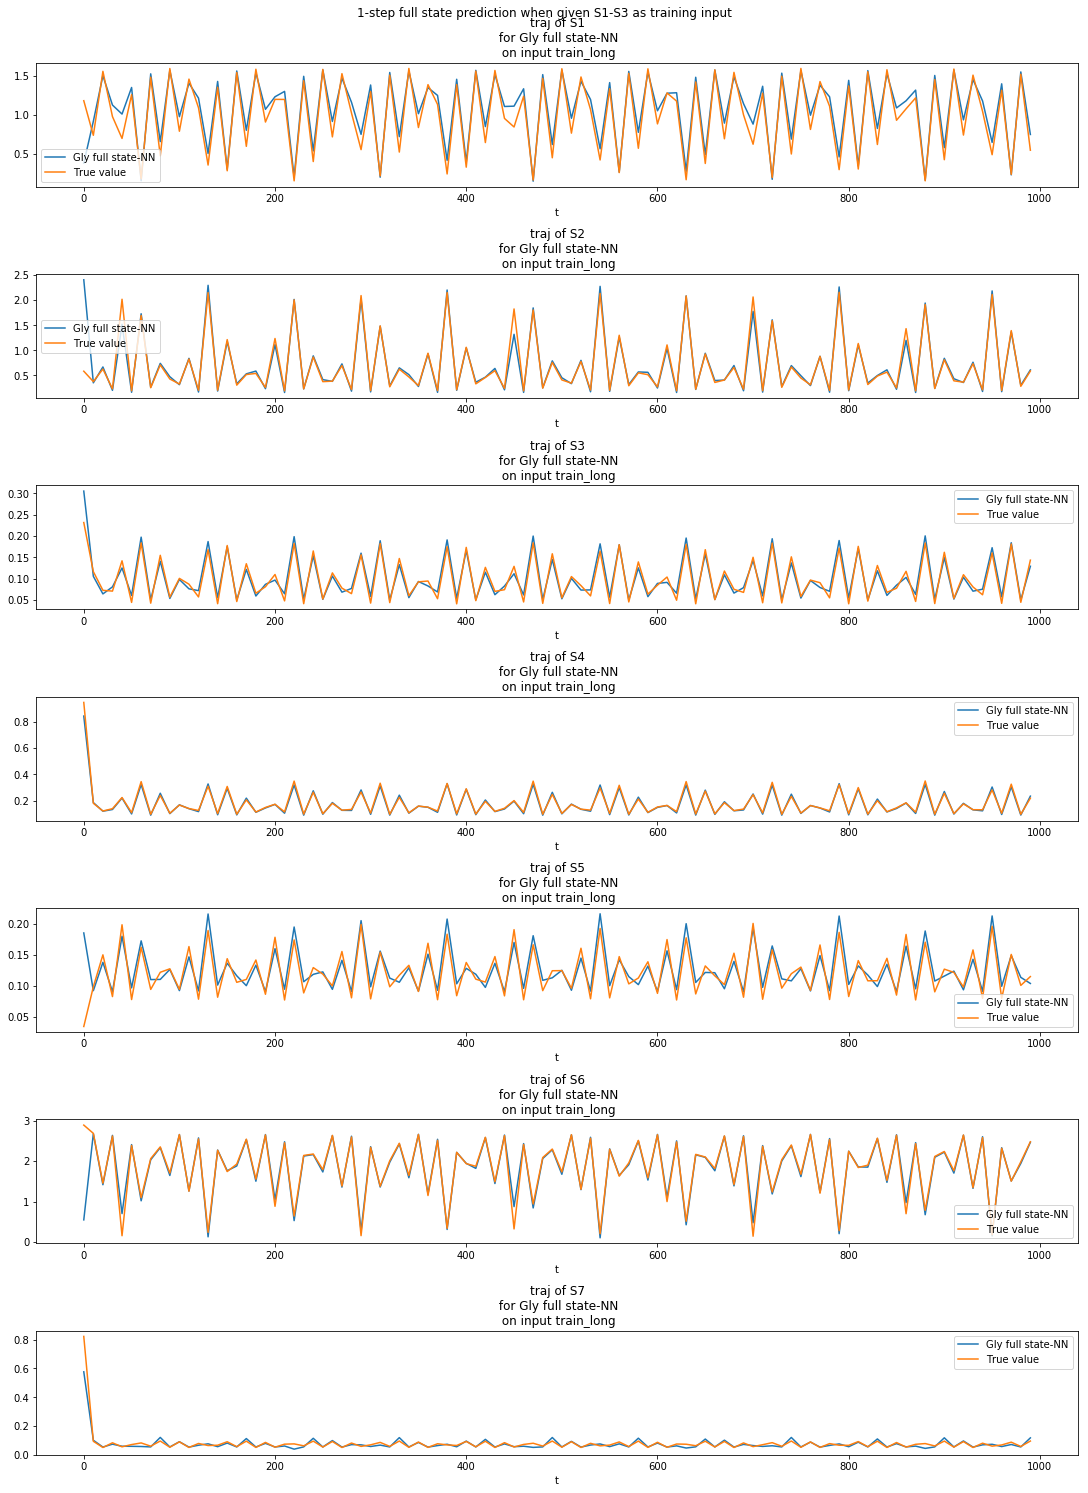

In [42]:
# Plots the test dataset with very long time range
fig, axs = plot_tests( test_inds=[2], net_list=net_listF, net_inds=[0], out_list=[0,1,2,3,4,5,6], 
                       net_names=net_names, u_names=u_names, out_names=out_names,
                       datatype='traj', log_mode=False, plot_skip_rate=1000, 
                       title='1-step full state prediction when given S1-S3 as training input\n' )
# fig, axs = plot_tests( test_inds=[2], net_list=net_listF, net_inds=[1], out_list=[0,1,2,3,4,5,6], 
#                        net_names=net_names, u_names=u_names, out_names=out_names,
#                        datatype='l2', log_mode=True, plot_skip_rate=500, 
#                        title='1-step full state prediction when given S1-S3 as training input\n' )

## Test other embedding methods

Cao et al. 1998

In [74]:
importlib.reload(sys.modules["embedding_methods"])
importlib.reload(sys.modules["embed_dynamics"])
# importlib.reload(sys.modules["system_dynamics"])
from embedding_methods import *
from embed_dynamics import *
X = gly_sys.Inputset[0][1:8]

In [64]:
find_delay_by_FNN_Cao( X[:6], pred=1, min_tau=1, max_tau=100, max_dim=10, 
                              init_i=0, end_early=True, verbose=True )

--- KNN (Cao 1998) initializing itself ---
At delay = 1, the AMI is 6.96164641724627.
At delay = 2, the AMI is 6.800300597721539.
At delay = 3, the AMI is 6.692483343177893.
At delay = 4, the AMI is 6.613395591706274.
At delay = 5, the AMI is 6.547133187362423.
At delay = 6, the AMI is 6.486731555682528.
At delay = 7, the AMI is 6.4328066408674065.
At delay = 8, the AMI is 6.385949117475639.
At delay = 9, the AMI is 6.342396449660222.
At delay = 10, the AMI is 6.2945921300169365.
At delay = 11, the AMI is 6.24795841699325.
At delay = 12, the AMI is 6.2089885600930685.
At delay = 13, the AMI is 6.177496129546274.
At delay = 14, the AMI is 6.147799133888513.
At delay = 15, the AMI is 6.122993186224053.
At delay = 16, the AMI is 6.09991663762428.
At delay = 17, the AMI is 6.084796560209444.
At delay = 18, the AMI is 6.069551010933072.
At delay = 19, the AMI is 6.060838598611295.
At delay = 20, the AMI is 6.049150604445882.
At delay = 21, the AMI is 6.033746948520396.
At delay = 22, the AM

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [42, 47, 53,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])

In [77]:
# Test out the chosen delay value. Set up nets.
tf.keras.backend.clear_session()
seed = 2020
opt_alg = 'adam'
activation = 'tanh' # 'relu' # 'tanh'
output_activation = 'none'
log_root_dir = 'Fma_logs/'
# input_masks = [ [1,2,3,4,5,6,7], 
#                 [1,2,3] ] # Allows S1-S3
input_masks = [ [1,2,3,4,5,6], 
                [1,2,3,7] ] 
Nlayer = 2
Nneuron = 5

net_listF = []
# Add two more models that don't use symmetry
for i in range(len(sys_list)):
    net_listF.append(
        embed_dynamics.NN_Cao(
            sys_list[i], input_masks[i], max_tau=100, max_de=10, verbose=True,
            seed=seed, log_dir=log_root_dir+sys_names[i], tensorboard=False,
            Nlayer=Nlayer, Nneuron=Nneuron, activation=activation, output_activation=output_activation, optimizer=opt_alg
        )
    )
net_names = [ sys_names[i]+'-NN' for i in range(len(sys_list)) ]

# Construct models
for nn in net_listF:
    nn.construct()


--- KNN (Cao 1998) initializing itself ---
At delay = 1, the AMI is 6.96164641724627.
At delay = 2, the AMI is 6.800300597721539.
At delay = 3, the AMI is 6.692483343177893.
At delay = 4, the AMI is 6.613395591706274.
At delay = 5, the AMI is 6.547133187362423.
At delay = 6, the AMI is 6.486731555682528.
At delay = 7, the AMI is 6.4328066408674065.
At delay = 8, the AMI is 6.385949117475639.
At delay = 9, the AMI is 6.342396449660222.
At delay = 10, the AMI is 6.2945921300169365.
At delay = 11, the AMI is 6.24795841699325.
At delay = 12, the AMI is 6.2089885600930685.
At delay = 13, the AMI is 6.177496129546274.
At delay = 14, the AMI is 6.147799133888513.
At delay = 15, the AMI is 6.122993186224053.
At delay = 16, the AMI is 6.09991663762428.
At delay = 17, the AMI is 6.084796560209444.
At delay = 18, the AMI is 6.069551010933072.
At delay = 19, the AMI is 6.060838598611295.
At delay = 20, the AMI is 6.049150604445882.
At delay = 21, the AMI is 6.03374802605203.
At delay = 22, the AMI

In [ ]:
# Train models. 
Epoch = 200
for nn in net_listF:
    nn.train(epoch=Epoch, inds=[0]) # inds is the dataset selected for training
    nn.summary()

In [ ]:
fig, axs = plot_tests( test_inds=[0,1], net_list=net_listF, net_inds=[0], out_list=[0,1,2,3,4,5,6], 
                       net_names=net_names, u_names=u_names, out_names=out_names,
                       datatype='l2', log_mode=True, plot_skip_rate=100, 
                       title='1-step full state prediction when given S1-S6 as training input\n' )

In [ ]:
fig, axs = plot_tests( test_inds=[0,1], net_list=net_listF, net_inds=[0], out_list=[0,1,2,3,4,5,6], 
                       net_names=net_names, u_names=u_names, out_names=out_names,
                       datatype='traj', log_mode=False, plot_skip_rate=100, 
                       title='1-step full state prediction when given S1-S6 as training input\n' )

In [ ]:
fig, axs = plot_tests( test_inds=[0,1], net_list=net_listF, net_inds=[1], out_list=[0,1,2,3,4,5,6], 
                       net_names=net_names, u_names=u_names, out_names=out_names,
                       datatype='l2', log_mode=True, plot_skip_rate=100, 
                       title='1-step full state prediction when given S1-S3,S7 as training input\n' )

In [ ]:
fig, axs = plot_tests( test_inds=[0,1], net_list=net_listF, net_inds=[1], out_list=[0,1,2,3,4,5,6], 
                       net_names=net_names, u_names=u_names, out_names=out_names,
                       datatype='traj', log_mode=False, plot_skip_rate=100, 
                       title='1-step full state prediction when given S1-S3,S7 as training input\n' )

In [ ]:
fig, axs = plot_tests( test_inds=[2], net_list=net_listF, net_inds=[0], out_list=[0,1,2,3,4,5,6], 
                       net_names=net_names, u_names=u_names, out_names=out_names,
                       datatype='traj', log_mode=False, plot_skip_rate=1000, 
                       title='1-step full state prediction when given S1-S6 as training input\n' )

Test out other non-FNN information-theory-related methods

In [92]:
# total correlation - this one can't run on full states, because the computation grows exponentially. 
# iterate_for_local_min(X[:4], method='KL', pairwise=False, end_early=False, verbose=True) <-- won't work
iterate_for_local_min(X[2:6], method='KL', pairwise=True, end_early=False, verbose=True)

At delay = 1, the AMI is 15.71060015139617.
At delay = 2, the AMI is 17.25404574827676.
1 is the optimal delay it found.
At delay = 3, the AMI is 17.234364955079847.
1 is the optimal delay it found.
At delay = 4, the AMI is 17.17144331643271.
1 is the optimal delay it found.
At delay = 5, the AMI is 17.107586295555553.
1 is the optimal delay it found.
At delay = 6, the AMI is 17.07196323376798.
1 is the optimal delay it found.
At delay = 7, the AMI is 16.966539301575935.
1 is the optimal delay it found.
At delay = 8, the AMI is 16.840474752136096.
1 is the optimal delay it found.
At delay = 9, the AMI is 16.742605817234214.
1 is the optimal delay it found.
At delay = 10, the AMI is 16.706029397413474.
1 is the optimal delay it found.
At delay = 11, the AMI is 16.725416009536644.
1 is the optimal delay it found.
At delay = 12, the AMI is 16.7397319569411.
1 is the optimal delay it found.
At delay = 13, the AMI is 16.700332393081545.
1 is the optimal delay it found.
At delay = 14, the AM

(1, True)

In [98]:
# KL divergence - this one can't run on full states, because the computation grows exponentially. 
# This is different from the one above. This one treats X and delayed X as total, separate distributions.
# iterate_for_local_min(X[2:4], method='total divergence', pairwise=False, end_early=False, verbose=True) #<-- won't work
iterate_for_local_min(X[:4], max_iter=50, method='total divergence', pairwise=True, end_early=False, verbose=True)

At delay = 1, the AMI is 7400.95969591008.
At delay = 2, the AMI is 7646.693350129048.
1 is the optimal delay it found.
At delay = 3, the AMI is 7810.49072604935.
1 is the optimal delay it found.
At delay = 4, the AMI is 7916.009230712002.
1 is the optimal delay it found.
At delay = 5, the AMI is 7982.550869083535.
1 is the optimal delay it found.
At delay = 6, the AMI is 8014.734157127564.
1 is the optimal delay it found.
At delay = 7, the AMI is 8020.047377212842.
1 is the optimal delay it found.
At delay = 8, the AMI is 8023.92458414709.
1 is the optimal delay it found.
At delay = 9, the AMI is 8029.138000487235.
1 is the optimal delay it found.
At delay = 10, the AMI is 8035.7161119354405.
1 is the optimal delay it found.
At delay = 11, the AMI is 8043.74611174388.
1 is the optimal delay it found.
At delay = 12, the AMI is 8053.350512546836.
1 is the optimal delay it found.
At delay = 13, the AMI is 8064.745792036801.
1 is the optimal delay it found.
At delay = 14, the AMI is 8078.

(1, True)

In [110]:
# interaction information - this one can't run on full states, because the computation grows exponentially. 
# I don't know if it'll even make sense to run this pairwisely, but here it goes...
iterate_for_local_min(X[2:6], method='interaction', pairwise=True, end_early=False, verbose=True)

At delay = 1, the AMI is 81.93562032278018.
At delay = 2, the AMI is 85.84714630428755.
1 is the optimal delay it found.
At delay = 3, the AMI is 86.58523818756656.
1 is the optimal delay it found.
At delay = 4, the AMI is 87.21022341459096.
1 is the optimal delay it found.
At delay = 5, the AMI is 87.75960902465191.
1 is the optimal delay it found.
At delay = 6, the AMI is 88.1881203547498.
1 is the optimal delay it found.
At delay = 7, the AMI is 88.25386678550173.
1 is the optimal delay it found.
At delay = 8, the AMI is 88.25676554051363.
1 is the optimal delay it found.
At delay = 9, the AMI is 88.288981153313.
1 is the optimal delay it found.
At delay = 10, the AMI is 88.31847552546584.
1 is the optimal delay it found.
At delay = 11, the AMI is 88.33785852831387.
1 is the optimal delay it found.
At delay = 12, the AMI is 88.35930135333946.
1 is the optimal delay it found.
At delay = 13, the AMI is 88.39702322682048.
1 is the optimal delay it found.
At delay = 14, the AMI is 88.44

(1, True)

In [128]:
# Distance-to-Diagonal, non-pairwise (it doesn't make sense to use pairwise)
iterate_for_local_min(X[2:6], method='DD', max_iter=100, pairwise=False, end_early=False, verbose=True)

At delay = 1, the AMI is -0.03748963437919128.
At delay = 2, the AMI is -0.133106389670752.
At delay = 3, the AMI is -0.27179092426404716.
At delay = 4, the AMI is -0.4398165926082773.
At delay = 5, the AMI is -0.6240900514518112.
At delay = 6, the AMI is -0.8154140217499657.
At delay = 7, the AMI is -1.0079186179708224.
At delay = 8, the AMI is -1.1974646703953895.
At delay = 9, the AMI is -1.3814037003036792.
At delay = 10, the AMI is -1.5576763190782539.
At delay = 11, the AMI is -1.7249038533342027.
At delay = 12, the AMI is -1.8821869844502974.
At delay = 13, the AMI is -2.0284489901693785.
At delay = 14, the AMI is -2.1629194132032783.
At delay = 15, the AMI is -2.2849941746573235.
At delay = 16, the AMI is -2.3942190044486398.
At delay = 17, the AMI is -2.4904188586748086.
At delay = 18, the AMI is -2.573265759255327.
At delay = 19, the AMI is -2.642491556171619.
At delay = 20, the AMI is -2.6979633950817634.
At delay = 21, the AMI is -2.739633482442677.
At delay = 22, the AMI i

(24, True)

In [130]:
# Average Displacement, non-pairwise (it doesn't make sense to use pairwise)
iterate_for_local_min(X[2:6], method='AD', max_iter=100, pairwise=False, end_early=False, verbose=True)

At delay = 1, the AMI is 0.43044440484673757.
At delay = 2, the AMI is 0.8495124203949709.
1 is the optimal delay it found.
At delay = 3, the AMI is 1.2484020464022998.
1 is the optimal delay it found.
At delay = 4, the AMI is 1.6140996395712421.
1 is the optimal delay it found.
At delay = 5, the AMI is 1.943418258152054.
1 is the optimal delay it found.
At delay = 6, the AMI is 2.2411849640945687.
1 is the optimal delay it found.
At delay = 7, the AMI is 2.511960234323727.
1 is the optimal delay it found.
At delay = 8, the AMI is 2.758335172487844.
1 is the optimal delay it found.
At delay = 9, the AMI is 2.982247972930248.
1 is the optimal delay it found.
At delay = 10, the AMI is 3.184886931462117.
1 is the optimal delay it found.
At delay = 11, the AMI is 3.3669131355331814.
1 is the optimal delay it found.
At delay = 12, the AMI is 3.528777035487481.
1 is the optimal delay it found.
At delay = 13, the AMI is 3.6704832902013087.
1 is the optimal delay it found.
At delay = 14, the A

(1, True)

In [134]:
# Garcia with 1D local minimum criterion
find_delay_by_FNN_Garcia(X, ratio=1.15, pred=1, stop_threshold=0, max_tau=30, max_dim=10,
                         init_i=0, end_early=True, verbose=True, inverse=False, twoD=False)

Starting the 1-th embedding cycle
At delay=1 using j=0 for de=0: average d1 = 0.00549200836413464; average d2 = 0.005510719535773712
105 out of 9968 samples counted as false neighbors
At delay=1 using j=1 for de=0: average d1 = 0.005554402073790368; average d2 = 0.005590145396559451
202 out of 9968 samples counted as false neighbors
At delay=1 using j=2 for de=0: average d1 = 0.00497337873546979; average d2 = 0.004971145244520707
0 out of 9968 samples counted as false neighbors
At delay=1 using j=3 for de=0: average d1 = 0.004986676367662435; average d2 = 0.004984659415266209
0 out of 9968 samples counted as false neighbors
At delay=1 using j=4 for de=0: average d1 = 0.004961302183558986; average d2 = 0.00495867234350822
0 out of 9968 samples counted as false neighbors
At delay=1 using j=5 for de=0: average d1 = 0.0058340755977996225; average d2 = 0.005920188323607222
257 out of 9968 samples counted as false neighbors
At delay=1 using j=6 for de=0: average d1 = 0.004964788589108723; av

([0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [0.010533707865168539,
  0.016755292465134946,
  0.020770620108368453,
  0.02388359257400903,
  0.025592131674026495,
  0.027802870621298804,
  0.029712909054406746,
  0.03142254793695412,
  0.03293172690763052,
  0.033738327141279244])

In [139]:
# Garcia with 1D local MAXimum criterion
find_delay_by_FNN_Garcia(X[:4], ratio=1.15, pred=1, stop_threshold=0, max_tau=20, max_dim=10,
                         init_i=0, end_early=True, verbose=True, local_max=True, inverse=False, twoD=False)

Starting the 1-th embedding cycle
At delay=1 using j=0 for de=0: average d1 = 0.003629077180195316; average d2 = 0.003684046832885359
158 out of 9978 samples counted as false neighbors
At delay=1 using j=1 for de=0: average d1 = 0.0037204451313721234; average d2 = 0.0038865256086927807
453 out of 9978 samples counted as false neighbors
At delay=1 using j=2 for de=0: average d1 = 0.003173241091767523; average d2 = 0.003166714016417036
0 out of 9978 samples counted as false neighbors
At delay=1 using j=3 for de=0: average d1 = 0.0031859995303533226; average d2 = 0.0031785489627800924
0 out of 9978 samples counted as false neighbors
At delay=2 using j=0 for de=0: average d1 = 0.0036621026319820045; average d2 = 0.0037333916751909188
189 out of 9978 samples counted as false neighbors
At delay=2 using j=1 for de=0: average d1 = 0.003810010354003501; average d2 = 0.003939406171977844
467 out of 9978 samples counted as false neighbors
At delay=2 using j=2 for de=0: average d1 = 0.003166708771

([1, 1, 1, 1, 0, 0, 2, 2, 3, 2],
 [3, 2, 2, 1, 1, 1, 3, 1, 1, 3],
 [0.04700340749649228,
  0.05974937343358396,
  0.06467462147799058,
  0.0652893390833417,
  0.06760280842527583,
  0.07172233925168021,
  0.07213081861958266,
  0.07205218263923734,
  0.07035327177840225,
  0.06995884773662552])

In [19]:
# Garcia with 1D local minimum and backwards embedding
find_delay_by_FNN_Garcia(X[:6], ratio=1, pred=1, stop_threshold=0, max_tau=20, max_dim=10,
                         init_i=0, end_early=True, verbose=True, local_max=True, inverse=True, twoD=False)

Starting the 1-th embedding cycle
At delay=-1 using j=0 for de=0: average d1 = 0.005418382224846096; average d2 = 0.005385015125548029
3773 out of 9998 samples counted as false neighbors
At delay=-1 using j=1 for de=0: average d1 = 0.005431353059697093; average d2 = 0.005412158632597321
4980 out of 9998 samples counted as false neighbors
At delay=-1 using j=2 for de=0: average d1 = 0.004866835054403229; average d2 = 0.004853093896542076
5706 out of 9998 samples counted as false neighbors
At delay=-1 using j=3 for de=0: average d1 = 0.004877011739715633; average d2 = 0.004870198647684362
3748 out of 9998 samples counted as false neighbors
At delay=-1 using j=4 for de=0: average d1 = 0.004876880801982996; average d2 = 0.004842787991786883
4436 out of 9998 samples counted as false neighbors
At delay=-1 using j=5 for de=0: average d1 = 0.005696230113348253; average d2 = 0.00566540457396249
6772 out of 9998 samples counted as false neighbors
At delay=-2 using j=0 for de=0: average d1 = 0.00

([0, 4, 3, 4, 0, 2, 4, 0, 0, 0],
 [4, 3, 2, 5, 2, 5, 2, 5, 4, 2],
 [0.37778889444722363,
  0.3733987189751801,
  0.34724724724724726,
  0.34411617426139207,
  0.360713212461184,
  0.373120865904991,
  0.3695870088211708,
  0.40968809547688295,
  0.421290257850908,
  0.42799799297541397])

In [44]:
importlib.reload(sys.modules["embedding_methods"])
importlib.reload(sys.modules["embed_dynamics"])
# importlib.reload(sys.modules["system_dynamics"])
from embedding_methods import *
from embed_dynamics import *
X = gly_sys.Inputset[0][1:8]

In [45]:
# Kennel "original" method
find_delay_by_FNN_Kennel(X[:4], ratio=1.0, pred=1, stop_threshold=0.001, max_tau=100, max_dim=10, uniform_delay=False, 
                              init_i=0, end_early=True, inverse=True, verbose=True)

--- KNN (Kennel 1992) initializing itself ---
At delay = 1, the AMI is 6.96164641724627.
At delay = 2, the AMI is 6.800300597721539.
At delay = 3, the AMI is 6.692483343177893.
At delay = 4, the AMI is 6.613395591706274.
At delay = 5, the AMI is 6.547133187362423.
At delay = 6, the AMI is 6.486731555682528.
At delay = 7, the AMI is 6.4328066408674065.
At delay = 8, the AMI is 6.385949117475639.
At delay = 9, the AMI is 6.342396449660222.
At delay = 10, the AMI is 6.2945921300169365.
At delay = 11, the AMI is 6.24795841699325.
At delay = 12, the AMI is 6.2089885600930685.
At delay = 13, the AMI is 6.177496129546274.
At delay = 14, the AMI is 6.147799133888513.
At delay = 15, the AMI is 6.122993186224053.
At delay = 16, the AMI is 6.09991663762428.
At delay = 17, the AMI is 6.084796560209444.
At delay = 18, the AMI is 6.069551010933072.
At delay = 19, the AMI is 6.060838598611295.
At delay = 20, the AMI is 6.049117204312282.
At delay = 21, the AMI is 6.033746948520396.
At delay = 22, the

([0, 1, 2, 3, 3, 3, 3],
 [0, 29, 44, 35, 59, 65, 71, 74],
 array([[29,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [44,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [35,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [59, 65, 71, 74,  0,  0,  0,  0,  0,  0]]))

## Scrap paper area - you don't have to remember what they were used for.

In [400]:
dinn, doutt = delay_embed_Garcia(
    net_listF[0].js, net_listF[0].tts, [i[1:4,:] for i in gly_sys.Inputset], gly_sys.Outputset, pred)

In [420]:
net_listF[0].dynamics.Inputset[1][0]

array([0.000e+00, 1.000e-02, 2.000e-02, ..., 9.997e+01, 9.998e+01,
       9.999e+01])

In [395]:
(Iset, Oset) = net_listF[0].train_data_generation_helper()

In [465]:
net_listF[0].js, net_listF[0].ts

([0], [4])

In [397]:
Oset.shape

(19990, 7, 1)

In [409]:
net_listF[0].output_shape

In [20]:
aaa = [1,2]
bbb = [3,4]
ccc = (aaa,bbb)

In [21]:
aaa.append(3)
ccc

([1, 2, 3], [3, 4])

In [22]:
bbb = [4,5]
ccc

([1, 2, 3], [3, 4])

In [23]:
ccc = (aaa[:],np.copy(bbb))
ccc

([1, 2, 3], array([4, 5]))

In [24]:
aaa.append(4)
bbb[0] = 7
ccc

([1, 2, 3], array([4, 5]))

In [26]:
aaa

[1, 2, 3, 4]